In [1]:
!pip install wordcloud pymorphy3 pymorphy3-dicts-uk openai

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import pymorphy3
import re


from collections import Counter
from collections import defaultdict
from dotenv import load_dotenv
from tqdm import tqdm
from wordcloud import WordCloud

In [3]:
memes_df = pd.read_csv('warmemes.csv')
memes_df

,month,year,meme_id,image_path,related,event,meme,history,creator,tags,event_ua,meme_ua,history_ua,tags_ua
0,february,2022.0,war,images/war.jpg,war-and-peace;100-days-of-war;february,Putin declared war on Ukraine,War,NaN,NaN,2022;war,Путін оголосив війну Україні,Війна,NaN,2022 рік;війни
1,february,2022.0,war-and-peace,images/war-and-peace.png,100-days-of-war;february;war,Russian authorities forbade to call Russian in...,War and peace,"Probably, the famous Leo Tolstoy's novel ""War ...",NaN,war;special military operation,Російська влада заборонила називати російське ...,Війна і мир,"Мабуть, відомий роман Льва Толстого «Війна і м...",війни;військова спецоперація
2,february,2022.0,scale-of-ukrainian-heroism,images/scale-of-ukrainian-heroism.jpg,sleep-well-little-tank;every-morning;day-160;w...,"After several days, it became evident that Ukr...",Scale of Ukrainian heroism,This meme is comparing the size of two countri...,NaN,russia;resilience;Ukraine,"Через кілька днів стало зрозуміло, що Україна ...",Масштаби українського героїзму,Цей мем порівнює розміри двох країн: України т...,росія;стійкість;Україна
3,february,2022.0,ghost-of-kyiv,images/ghost-of-kyiv.png,orlando-bloom;kyiv-in-3-days;borodianka-cat;ky...,Russia was unable to establish air superiority...,Ghost of Kyiv,Ghost of Kyiv is a nickname given to a mythica...,NaN,Kyiv;aircraft;airplanes;Ghost of Kyiv,Росія не змогла встановити перевагу в повітрі ...,Привид Києва,"Привид Києва — це прізвисько, яке дали міфічно...",Київ;літак;літаки;Привид Києва
4,february,2022.0,sunflower-seeds,images/sunflower-seeds.webp,NaN,A Ukrainian woman told Russian soldier: ‘Put s...,Sunflower seeds,A viral video appeared showing a Ukrainian wom...,NaN,sunflower;seeds;occupiers,Українка сказала російському солдату: «Поклади...,Насіння соняшнику,"З&#39;явилося вірусне відео, на якому українка...",соняшник;насіння;окупанти
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,october,2024.0,nafo-2,images/nafo-2.jpg,dirty-bomb;fundraising-for-nuclear;proton;nato...,NaN,NAFO,NaN,NaN,nuclear;NAFO,NaN,НАФО,NaN,ядерний;НАФО
219,october,2024.0,nato-or-nuclear,images/nato-or-nuclear.jpg,nafo-2;finland-nato;dirty-bomb;nato;proton;fun...,Zelensky told NATO members that Ukraine must e...,NATO or nuclear,NaN,NaN,nuclear;NATO,"Зеленський заявив членам НАТО, що Україна має ...",НАТО чи ядерна,NaN,ядерний;НАТО
220,october,2024.0,last-day,images/last-day.jpg,NaN,Ukraine adopted the law to cancel Daylight Sav...,Last day,"The text says ""The daylight savings switch wil...",NaN,daylight saving,В Україні ухвалили закон про скасування перехо...,Останній день,У тексті сказано: «Перехід на літній та зимови...,літній час
221,november,2024.0,700000-2,images/700000-2.jpg,NaN,NaN,700000,NaN,NaN,700000;dead russian,NaN,700000,NaN,700000;мертвий росіянин


# Tags Investigation

In [4]:
tags = memes_df[memes_df["tags_ua"].notna()]["tags_ua"].str.split(';')

tags_list = [item for sublist in tags for item in sublist]
unique_tags = set(tags_list)

In [5]:
unique_tags

{'100 днів',
 '100000',
 '200000',
 '2022 рік',
 '2023 рік',
 '2024 рік',
 '500 000',
 '700000',
 '8 березня',
 '9 травня',
 'ATACMS',
 'Chornobyl',
 'KIA',
 'Kalush orchestra',
 'Maliuk',
 'Medvedchuk',
 'Mriya',
 'Okhmatdyt',
 'Prytula',
 'Sergey Kotov',
 'YouTube',
 'Zaporizhzhia',
 'Zelenskiy',
 'Zelenskyi',
 'borshch',
 'borshcht',
 'iphone',
 'palyanytsia',
 'pantone',
 'spotify',
 'vyshyvanka',
 'Євро 2024',
 'Євробачення',
 'І',
 'Ізраїль',
 'Іран',
 'А-50',
 'Бавовна',
 'Байден',
 'Блимання',
 'Бородянка',
 'Буданов',
 'Білгород',
 'ВПС України',
 'Вагнера',
 'Великдень',
 'Володар кілець',
 'ГУР',
 'Гаага',
 'Гаррі Поттер',
 'Джордж Мартін',
 'ЗАЕС',
 'Залужний',
 'Каховка',
 'Київ',
 'Київська обл',
 'Кличко',
 'Конашенков',
 'Конгрес',
 'Кримський міст',
 'Курськ',
 'Кінжал',
 'Леголас',
 'Майк Джонсон',
 'Макрон',
 'Маріуполь',
 'Москва',
 'Мускус',
 'Міноборони Росії',
 'НАТО',
 'НАФО',
 'Навальний',
 'Новий рік',
 'Німеччина',
 'Оборонна розвідка',
 'Орбан',
 'Орландо Бл

### Manual Tags Translation

As we can see there are several non translated tags. Let's handle them manually.

In [6]:
def contains_non_cyrillic(s):
    return bool(re.search(r'[^\u0400-\u04FF]', ''.join(re.findall(r'[a-zA-Z\u0400-\u04FF]', s))))

In [7]:
not_translated_tags = []
for tag in list(unique_tags):
    if contains_non_cyrillic(tag):
        not_translated_tags.append(tag)
        
not_translated_tags

['Zaporizhzhia',
 'borshch',
 'iphone',
 'Maliuk',
 'borshcht',
 'YouTube',
 'pantone',
 'vyshyvanka',
 'ATACMS',
 'Sergey Kotov',
 'KIA',
 'Prytula',
 'Okhmatdyt',
 'Mriya',
 'palyanytsia',
 'Chornobyl',
 'Zelenskiy',
 'spotify',
 'Zelenskyi',
 'Medvedchuk',
 'Kalush orchestra']

In [8]:
translations = {
    'Mriya': 'Мрія',
    'palyanytsia': 'паляниця',
    'Zelenskyi': 'Зеленський',
    'Zelenskiy': 'Зеленський',
    'Medvedchuk': 'Медведчук',
    'Chornobyl': 'Чорнобиль',
    'borshcht': 'борщ',
    'pantone': 'пантон',
    'vyshyvanka': 'вишиванка',
    'Zaporizhzhia': 'Запоріжжя',
    'Sergey Kotov': 'Сергій Котов',
    'Maliuk': 'Малюк',
    'Okhmatdyt': 'Охматдит',
    'borshch': 'борщ',
    'Prytula': 'Притула',
    'Ф-16': 'F-16', # translate back as it is named entity
    'ХІМАРС': 'HIMARS', # translate back as it is named entity
    'Кінжал': 'Кинджал'
}

manual_translate = lambda text: translations[text] if text in translations else text

In [9]:
memes_df.loc[:, 'tags_ua'] = memes_df.tags_ua.apply(lambda row: ';'.join([manual_translate(tag) for tag in str(row).split(';')]) if pd.notna(row) and row else None)
memes_df

,month,year,meme_id,image_path,related,event,meme,history,creator,tags,event_ua,meme_ua,history_ua,tags_ua
0,february,2022.0,war,images/war.jpg,war-and-peace;100-days-of-war;february,Putin declared war on Ukraine,War,NaN,NaN,2022;war,Путін оголосив війну Україні,Війна,NaN,2022 рік;війни
1,february,2022.0,war-and-peace,images/war-and-peace.png,100-days-of-war;february;war,Russian authorities forbade to call Russian in...,War and peace,"Probably, the famous Leo Tolstoy's novel ""War ...",NaN,war;special military operation,Російська влада заборонила називати російське ...,Війна і мир,"Мабуть, відомий роман Льва Толстого «Війна і м...",війни;військова спецоперація
2,february,2022.0,scale-of-ukrainian-heroism,images/scale-of-ukrainian-heroism.jpg,sleep-well-little-tank;every-morning;day-160;w...,"After several days, it became evident that Ukr...",Scale of Ukrainian heroism,This meme is comparing the size of two countri...,NaN,russia;resilience;Ukraine,"Через кілька днів стало зрозуміло, що Україна ...",Масштаби українського героїзму,Цей мем порівнює розміри двох країн: України т...,росія;стійкість;Україна
3,february,2022.0,ghost-of-kyiv,images/ghost-of-kyiv.png,orlando-bloom;kyiv-in-3-days;borodianka-cat;ky...,Russia was unable to establish air superiority...,Ghost of Kyiv,Ghost of Kyiv is a nickname given to a mythica...,NaN,Kyiv;aircraft;airplanes;Ghost of Kyiv,Росія не змогла встановити перевагу в повітрі ...,Привид Києва,"Привид Києва — це прізвисько, яке дали міфічно...",Київ;літак;літаки;Привид Києва
4,february,2022.0,sunflower-seeds,images/sunflower-seeds.webp,NaN,A Ukrainian woman told Russian soldier: ‘Put s...,Sunflower seeds,A viral video appeared showing a Ukrainian wom...,NaN,sunflower;seeds;occupiers,Українка сказала російському солдату: «Поклади...,Насіння соняшнику,"З&#39;явилося вірусне відео, на якому українка...",соняшник;насіння;окупанти
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,october,2024.0,nafo-2,images/nafo-2.jpg,dirty-bomb;fundraising-for-nuclear;proton;nato...,NaN,NAFO,NaN,NaN,nuclear;NAFO,NaN,НАФО,NaN,ядерний;НАФО
219,october,2024.0,nato-or-nuclear,images/nato-or-nuclear.jpg,nafo-2;finland-nato;dirty-bomb;nato;proton;fun...,Zelensky told NATO members that Ukraine must e...,NATO or nuclear,NaN,NaN,nuclear;NATO,"Зеленський заявив членам НАТО, що Україна має ...",НАТО чи ядерна,NaN,ядерний;НАТО
220,october,2024.0,last-day,images/last-day.jpg,NaN,Ukraine adopted the law to cancel Daylight Sav...,Last day,"The text says ""The daylight savings switch wil...",NaN,daylight saving,В Україні ухвалили закон про скасування перехо...,Останній день,У тексті сказано: «Перехід на літній та зимови...,літній час
221,november,2024.0,700000-2,images/700000-2.jpg,NaN,NaN,700000,NaN,NaN,700000;dead russian,NaN,700000,NaN,700000;мертвий росіянин


In [10]:
def remove_duplicates(tags):
    return ';'.join(set(tags.split(';')))

In [11]:
memes_df.loc[:, 'tags_ua'] = memes_df.tags_ua.apply(lambda row: remove_duplicates(row) if pd.notna(row) and row else None)

In [12]:
memes_df[memes_df.tags_ua == 'борщ;борщ']

,month,year,meme_id,image_path,related,event,meme,history,creator,tags,event_ua,meme_ua,history_ua,tags_ua


In [13]:
memes_df[memes_df.tags_ua == 'Зеленський;Зеленський']

,month,year,meme_id,image_path,related,event,meme,history,creator,tags,event_ua,meme_ua,history_ua,tags_ua


### Tags Lematization

In [14]:
tags = memes_df[memes_df["tags_ua"].notna()]["tags_ua"].str.split(';')

tags_list = [item for sublist in tags for item in sublist]
unique_tags = set(tags_list)

In [15]:
unique_tags

{'100 днів',
 '100000',
 '200000',
 '2022 рік',
 '2023 рік',
 '2024 рік',
 '500 000',
 '700000',
 '8 березня',
 '9 травня',
 'ATACMS',
 'F-16',
 'HIMARS',
 'KIA',
 'Kalush orchestra',
 'YouTube',
 'iphone',
 'spotify',
 'Євро 2024',
 'Євробачення',
 'І',
 'Ізраїль',
 'Іран',
 'А-50',
 'Бавовна',
 'Байден',
 'Блимання',
 'Бородянка',
 'Буданов',
 'Білгород',
 'ВПС України',
 'Вагнера',
 'Великдень',
 'Володар кілець',
 'ГУР',
 'Гаага',
 'Гаррі Поттер',
 'Джордж Мартін',
 'ЗАЕС',
 'Залужний',
 'Запоріжжя',
 'Зеленський',
 'Каховка',
 'Кинджал',
 'Київ',
 'Київська обл',
 'Кличко',
 'Конашенков',
 'Конгрес',
 'Кримський міст',
 'Курськ',
 'Леголас',
 'Майк Джонсон',
 'Макрон',
 'Малюк',
 'Маріуполь',
 'Медведчук',
 'Москва',
 'Мрія',
 'Мускус',
 'Міноборони Росії',
 'НАТО',
 'НАФО',
 'Навальний',
 'Новий рік',
 'Німеччина',
 'Оборонна розвідка',
 'Орбан',
 'Орландо Блум',
 'Орськ',
 'Оскар',
 'Охматдит',
 'ППО',
 'Патріот',
 'Привид Києва',
 'Пригожин',
 'Притула',
 'Путін',
 'Резніков',


In [16]:
len(unique_tags)

174

In [17]:
lemmatizer = pymorphy3.MorphAnalyzer(lang='uk')

lemma_to_tags = defaultdict(list)
for tag in list(unique_tags):
    if tag[0].isupper():
        lemma_to_tags[tag].append(tag)
    else:
        lemma_to_tags[lemmatizer.parse(tag)[0].normal_form].append(tag)

tags_to_lemmatize = {key: value for key, value in lemma_to_tags.items() if len(value) > 1}
tags_to_lemmatize

{'літак': ['літак', 'літаки'], 'дрон': ['дрони', 'дрон']}

In [18]:
change = {}
for lemma, tags in tags_to_lemmatize.items():
    for tag in tags:
        change[tag] = lemma
change

{'літак': 'літак', 'літаки': 'літак', 'дрони': 'дрон', 'дрон': 'дрон'}

In [19]:
manual_change = lambda text: change[text] if text in change else text

memes_df.loc[:, 'tags_ua'] = memes_df.tags_ua.apply(lambda row: ';'.join([manual_change(tag) for tag in str(row).split(';')]) if pd.notna(row) and row else None)

In [20]:
tags = memes_df[memes_df["tags_ua"].notna()]["tags_ua"].str.split(';')

tags_list = [item for sublist in tags for item in sublist]
tags_counts = dict(Counter(tags_list))

In [21]:
len(tags_counts)

172

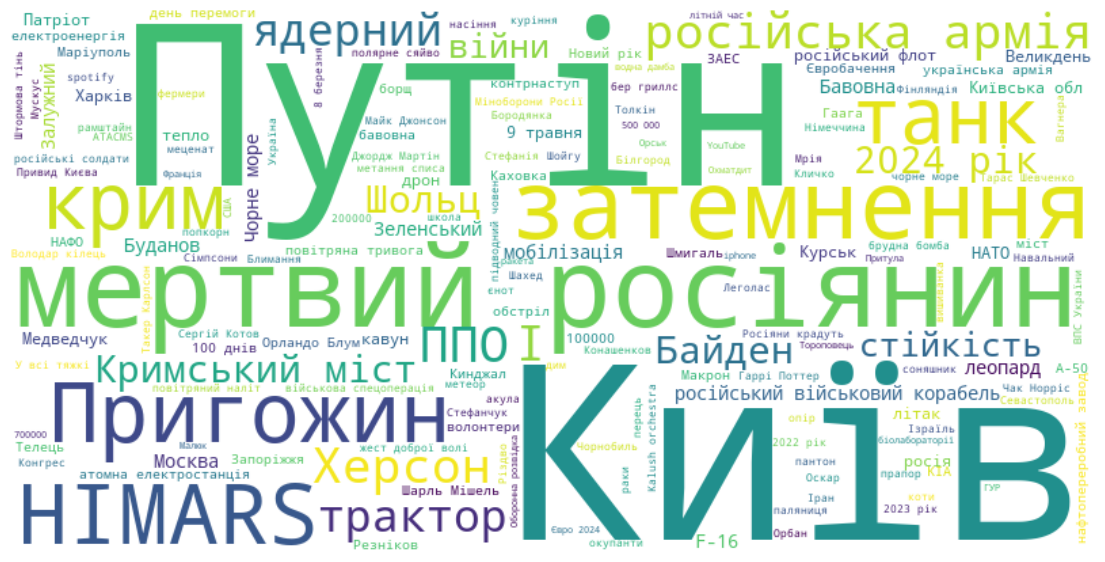

In [24]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tags_counts)

plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### NER within Tags

In [25]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")


def find_named_entity(text):
    prompt = (
        f"Define if the following word or phrase contain one of the named entities: "
        f"organization_name, person_name, location_name, weapon_name, or not_named_entity.\n\n"
        f"Text: {text}\n\n"
        f"Response:"
    )

    response = openai.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=50
    )

    category = response.choices[0].text.strip()
    return category

In [26]:
entity_columns = ["organization_name", "person_name", "location_name", "weapon_name"]
for col in entity_columns:
    memes_df[col] = np.nan
    memes_df[col] = memes_df[col].astype(object)

for index, row in tqdm(memes_df.iterrows()):
    if row['tags_ua']:
        tags = row['tags_ua'].split(";")
        if tags:
            for tag in tags:
                category = find_named_entity(tag)
                if category in entity_columns:
                    if not(pd.isna(memes_df.at[index, category])):
                        memes_df.at[index, category] += f";{tag}"
                    else:
                        memes_df.at[index, category] = tag

memes_df

223it [03:13,  1.15it/s]


,month,year,meme_id,image_path,related,event,meme,history,creator,tags,event_ua,meme_ua,history_ua,tags_ua,organization_name,person_name,location_name,weapon_name
0,february,2022.0,war,images/war.jpg,war-and-peace;100-days-of-war;february,Putin declared war on Ukraine,War,NaN,NaN,2022;war,Путін оголосив війну Україні,Війна,NaN,2022 рік;війни,NaN,NaN,NaN,NaN
1,february,2022.0,war-and-peace,images/war-and-peace.png,100-days-of-war;february;war,Russian authorities forbade to call Russian in...,War and peace,"Probably, the famous Leo Tolstoy's novel ""War ...",NaN,war;special military operation,Російська влада заборонила називати російське ...,Війна і мир,"Мабуть, відомий роман Льва Толстого «Війна і м...",військова спецоперація;війни,NaN,NaN,NaN,NaN
2,february,2022.0,scale-of-ukrainian-heroism,images/scale-of-ukrainian-heroism.jpg,sleep-well-little-tank;every-morning;day-160;w...,"After several days, it became evident that Ukr...",Scale of Ukrainian heroism,This meme is comparing the size of two countri...,NaN,russia;resilience;Ukraine,"Через кілька днів стало зрозуміло, що Україна ...",Масштаби українського героїзму,Цей мем порівнює розміри двох країн: України т...,росія;стійкість;Україна,NaN,NaN,росія;Україна,NaN
3,february,2022.0,ghost-of-kyiv,images/ghost-of-kyiv.png,orlando-bloom;kyiv-in-3-days;borodianka-cat;ky...,Russia was unable to establish air superiority...,Ghost of Kyiv,Ghost of Kyiv is a nickname given to a mythica...,NaN,Kyiv;aircraft;airplanes;Ghost of Kyiv,Росія не змогла встановити перевагу в повітрі ...,Привид Києва,"Привид Києва — це прізвисько, яке дали міфічно...",Привид Києва;літак;літак;Київ,NaN,NaN,Привид Києва;Київ,NaN
4,february,2022.0,sunflower-seeds,images/sunflower-seeds.webp,NaN,A Ukrainian woman told Russian soldier: ‘Put s...,Sunflower seeds,A viral video appeared showing a Ukrainian wom...,NaN,sunflower;seeds;occupiers,Українка сказала російському солдату: «Поклади...,Насіння соняшнику,"З&#39;явилося вірусне відео, на якому українка...",насіння;окупанти;соняшник,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,october,2024.0,nafo-2,images/nafo-2.jpg,dirty-bomb;fundraising-for-nuclear;proton;nato...,NaN,NAFO,NaN,NaN,nuclear;NAFO,NaN,НАФО,NaN,ядерний;НАФО,NaN,NaN,NaN,NaN
219,october,2024.0,nato-or-nuclear,images/nato-or-nuclear.jpg,nafo-2;finland-nato;dirty-bomb;nato;proton;fun...,Zelensky told NATO members that Ukraine must e...,NATO or nuclear,NaN,NaN,nuclear;NATO,"Зеленський заявив членам НАТО, що Україна має ...",НАТО чи ядерна,NaN,ядерний;НАТО,НАТО,NaN,NaN,NaN
220,october,2024.0,last-day,images/last-day.jpg,NaN,Ukraine adopted the law to cancel Daylight Sav...,Last day,"The text says ""The daylight savings switch wil...",NaN,daylight saving,В Україні ухвалили закон про скасування перехо...,Останній день,У тексті сказано: «Перехід на літній та зимови...,літній час,NaN,NaN,NaN,NaN
221,november,2024.0,700000-2,images/700000-2.jpg,NaN,NaN,700000,NaN,NaN,700000;dead russian,NaN,700000,NaN,мертвий росіянин;700000,NaN,NaN,NaN,NaN


In [27]:
memes_df.organization_name.unique()

array([nan, 'Kalush orchestra', 'Міноборони Росії', 'НАТО', 'spotify',
       'ВПС України', 'нафтопереробний завод', 'YouTube',
       'Оборонна розвідка;ГУР'], dtype=object)

In [28]:
organizations_to_remove = ['Kalush orchestra', 'spotify', 'нафтопереробний завод', 'YouTube']

In [29]:
memes_df.person_name.unique()

array([nan, 'Путін;Шойгу', 'Зеленський', 'Медведчук',
       'Шмигаль;Резніков;Шарль Мішель', 'Стефанія', 'Зеленський;Макрон',
       'Чак Норріс', 'Конашенков', 'Путін', 'Зеленський;Байден',
       'Кличко;Стефанчук', 'Байден', 'Резніков',
       'Зеленський;Толкін;Байден', 'Путін;Байден', 'Путін;Орландо Блум',
       'Леголас;Орландо Блум', 'Навальний', 'Буданов;Пригожин',
       'Путін;Пригожин', 'Пригожин', 'Буданов', 'Гаррі Поттер',
       'Джордж Мартін', 'Путін;Орбан', 'Майк Джонсон',
       'Путін;Такер Карлсон', 'Тарас Шевченко', 'Сергій Котов', 'Макрон',
       'Шмигаль;Шарль Мішель'], dtype=object)

In [30]:
persons_to_remove = ['Стефанія']

In [31]:
memes_df.location_name.unique()

array([nan, 'росія;Україна', 'Привид Києва;Київ', 'Київська обл', 'Київ',
       'Москва', 'Чорнобиль', 'Київська обл;Київ',
       'Київська обл;Київ;Бородянка', 'Білгород', 'Херсон', 'Харків',
       'Іран', 'Кримський міст', 'росія', 'Німеччина', 'Маріуполь',
       'Маріуполь;Київ', 'Гаага', 'Севастополь', 'Фінляндія', 'Каховка',
       'Запоріжжя', 'Ізраїль', 'США', 'Орськ', 'Франція', 'Курськ'],
      dtype=object)

In [32]:
locations_to_remove = ['Привид Києва', 'Кримський міст']

In [33]:
memes_df.weapon_name.unique()

array([nan, 'танк', 'HIMARS', 'F-16', 'Кинджал', 'KIA', 'ATACMS'],
      dtype=object)

In [34]:
weapons_to_remove = ['танк', 'KIA']

In [35]:
def remove_value(cell, values_to_remove):
    values = [val.strip() for val in cell.split(';')]
    filtered_values = [val for val in values if val not in set(values_to_remove)]
    return ';'.join(filtered_values) if filtered_values else np.nan

In [36]:
memes_df.organization_name = memes_df.organization_name.apply(lambda row: remove_value(row, organizations_to_remove) if pd.notna(row) and row else row)
memes_df.person_name = memes_df.person_name.apply(lambda row: remove_value(row, persons_to_remove) if pd.notna(row) and row else row)
memes_df.location_name = memes_df.location_name.apply(lambda row: remove_value(row, locations_to_remove) if pd.notna(row) and row else row)
memes_df.weapon_name = memes_df.weapon_name.apply(lambda row: remove_value(row, weapons_to_remove) if pd.notna(row) and row else row)

In [37]:
memes_df

,month,year,meme_id,image_path,related,event,meme,history,creator,tags,event_ua,meme_ua,history_ua,tags_ua,organization_name,person_name,location_name,weapon_name
0,february,2022.0,war,images/war.jpg,war-and-peace;100-days-of-war;february,Putin declared war on Ukraine,War,NaN,NaN,2022;war,Путін оголосив війну Україні,Війна,NaN,2022 рік;війни,NaN,NaN,NaN,NaN
1,february,2022.0,war-and-peace,images/war-and-peace.png,100-days-of-war;february;war,Russian authorities forbade to call Russian in...,War and peace,"Probably, the famous Leo Tolstoy's novel ""War ...",NaN,war;special military operation,Російська влада заборонила називати російське ...,Війна і мир,"Мабуть, відомий роман Льва Толстого «Війна і м...",військова спецоперація;війни,NaN,NaN,NaN,NaN
2,february,2022.0,scale-of-ukrainian-heroism,images/scale-of-ukrainian-heroism.jpg,sleep-well-little-tank;every-morning;day-160;w...,"After several days, it became evident that Ukr...",Scale of Ukrainian heroism,This meme is comparing the size of two countri...,NaN,russia;resilience;Ukraine,"Через кілька днів стало зрозуміло, що Україна ...",Масштаби українського героїзму,Цей мем порівнює розміри двох країн: України т...,росія;стійкість;Україна,NaN,NaN,росія;Україна,NaN
3,february,2022.0,ghost-of-kyiv,images/ghost-of-kyiv.png,orlando-bloom;kyiv-in-3-days;borodianka-cat;ky...,Russia was unable to establish air superiority...,Ghost of Kyiv,Ghost of Kyiv is a nickname given to a mythica...,NaN,Kyiv;aircraft;airplanes;Ghost of Kyiv,Росія не змогла встановити перевагу в повітрі ...,Привид Києва,"Привид Києва — це прізвисько, яке дали міфічно...",Привид Києва;літак;літак;Київ,NaN,NaN,Київ,NaN
4,february,2022.0,sunflower-seeds,images/sunflower-seeds.webp,NaN,A Ukrainian woman told Russian soldier: ‘Put s...,Sunflower seeds,A viral video appeared showing a Ukrainian wom...,NaN,sunflower;seeds;occupiers,Українка сказала російському солдату: «Поклади...,Насіння соняшнику,"З&#39;явилося вірусне відео, на якому українка...",насіння;окупанти;соняшник,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,october,2024.0,nafo-2,images/nafo-2.jpg,dirty-bomb;fundraising-for-nuclear;proton;nato...,NaN,NAFO,NaN,NaN,nuclear;NAFO,NaN,НАФО,NaN,ядерний;НАФО,NaN,NaN,NaN,NaN
219,october,2024.0,nato-or-nuclear,images/nato-or-nuclear.jpg,nafo-2;finland-nato;dirty-bomb;nato;proton;fun...,Zelensky told NATO members that Ukraine must e...,NATO or nuclear,NaN,NaN,nuclear;NATO,"Зеленський заявив членам НАТО, що Україна має ...",НАТО чи ядерна,NaN,ядерний;НАТО,НАТО,NaN,NaN,NaN
220,october,2024.0,last-day,images/last-day.jpg,NaN,Ukraine adopted the law to cancel Daylight Sav...,Last day,"The text says ""The daylight savings switch wil...",NaN,daylight saving,В Україні ухвалили закон про скасування перехо...,Останній день,У тексті сказано: «Перехід на літній та зимови...,літній час,NaN,NaN,NaN,NaN
221,november,2024.0,700000-2,images/700000-2.jpg,NaN,NaN,700000,NaN,NaN,700000;dead russian,NaN,700000,NaN,мертвий росіянин;700000,NaN,NaN,NaN,NaN


In [38]:
memes_df.organization_name.unique()

array([nan, 'Міноборони Росії', 'НАТО', 'ВПС України',
       'Оборонна розвідка;ГУР'], dtype=object)

In [39]:
memes_df.person_name.unique()

array([nan, 'Путін;Шойгу', 'Зеленський', 'Медведчук',
       'Шмигаль;Резніков;Шарль Мішель', 'Зеленський;Макрон', 'Чак Норріс',
       'Конашенков', 'Путін', 'Зеленський;Байден', 'Кличко;Стефанчук',
       'Байден', 'Резніков', 'Зеленський;Толкін;Байден', 'Путін;Байден',
       'Путін;Орландо Блум', 'Леголас;Орландо Блум', 'Навальний',
       'Буданов;Пригожин', 'Путін;Пригожин', 'Пригожин', 'Буданов',
       'Гаррі Поттер', 'Джордж Мартін', 'Путін;Орбан', 'Майк Джонсон',
       'Путін;Такер Карлсон', 'Тарас Шевченко', 'Сергій Котов', 'Макрон',
       'Шмигаль;Шарль Мішель'], dtype=object)

In [40]:
memes_df.location_name.unique()

array([nan, 'росія;Україна', 'Київ', 'Київська обл', 'Москва',
       'Чорнобиль', 'Київська обл;Київ', 'Київська обл;Київ;Бородянка',
       'Білгород', 'Херсон', 'Харків', 'Іран', 'росія', 'Німеччина',
       'Маріуполь', 'Маріуполь;Київ', 'Гаага', 'Севастополь', 'Фінляндія',
       'Каховка', 'Запоріжжя', 'Ізраїль', 'США', 'Орськ', 'Франція',
       'Курськ'], dtype=object)

In [41]:
memes_df.weapon_name.unique()

array([nan, 'HIMARS', 'F-16', 'Кинджал', 'ATACMS'], dtype=object)

In [42]:
memes_df.to_csv("warmemes.csv", index=False)

In [3]:
memes_df = pd.read_csv('warmemes.csv')
memes_df

,month,year,meme_id,image_path,related,event,meme,history,creator,tags,event_ua,meme_ua,history_ua,tags_ua,organization_name,person_name,location_name,weapon_name
0,february,2022.0,war,images/war.jpg,war-and-peace;100-days-of-war;february,Putin declared war on Ukraine,War,NaN,NaN,2022;war,Путін оголосив війну Україні,Війна,NaN,2022 рік;війни,NaN,NaN,NaN,NaN
1,february,2022.0,war-and-peace,images/war-and-peace.png,100-days-of-war;february;war,Russian authorities forbade to call Russian in...,War and peace,"Probably, the famous Leo Tolstoy's novel ""War ...",NaN,war;special military operation,Російська влада заборонила називати російське ...,Війна і мир,"Мабуть, відомий роман Льва Толстого «Війна і м...",військова спецоперація;війни,NaN,NaN,NaN,NaN
2,february,2022.0,scale-of-ukrainian-heroism,images/scale-of-ukrainian-heroism.jpg,sleep-well-little-tank;every-morning;day-160;w...,"After several days, it became evident that Ukr...",Scale of Ukrainian heroism,This meme is comparing the size of two countri...,NaN,russia;resilience;Ukraine,"Через кілька днів стало зрозуміло, що Україна ...",Масштаби українського героїзму,Цей мем порівнює розміри двох країн: України т...,росія;стійкість;Україна,NaN,NaN,росія;Україна,NaN
3,february,2022.0,ghost-of-kyiv,images/ghost-of-kyiv.png,orlando-bloom;kyiv-in-3-days;borodianka-cat;ky...,Russia was unable to establish air superiority...,Ghost of Kyiv,Ghost of Kyiv is a nickname given to a mythica...,NaN,Kyiv;aircraft;airplanes;Ghost of Kyiv,Росія не змогла встановити перевагу в повітрі ...,Привид Києва,"Привид Києва — це прізвисько, яке дали міфічно...",Привид Києва;літак;літак;Київ,NaN,NaN,Київ,NaN
4,february,2022.0,sunflower-seeds,images/sunflower-seeds.webp,NaN,A Ukrainian woman told Russian soldier: ‘Put s...,Sunflower seeds,A viral video appeared showing a Ukrainian wom...,NaN,sunflower;seeds;occupiers,Українка сказала російському солдату: «Поклади...,Насіння соняшнику,"З&#39;явилося вірусне відео, на якому українка...",насіння;окупанти;соняшник,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,october,2024.0,nafo-2,images/nafo-2.jpg,dirty-bomb;fundraising-for-nuclear;proton;nato...,NaN,NAFO,NaN,NaN,nuclear;NAFO,NaN,НАФО,NaN,ядерний;НАФО,NaN,NaN,NaN,NaN
219,october,2024.0,nato-or-nuclear,images/nato-or-nuclear.jpg,nafo-2;finland-nato;dirty-bomb;nato;proton;fun...,Zelensky told NATO members that Ukraine must e...,NATO or nuclear,NaN,NaN,nuclear;NATO,"Зеленський заявив членам НАТО, що Україна має ...",НАТО чи ядерна,NaN,ядерний;НАТО,НАТО,NaN,NaN,NaN
220,october,2024.0,last-day,images/last-day.jpg,NaN,Ukraine adopted the law to cancel Daylight Sav...,Last day,"The text says ""The daylight savings switch wil...",NaN,daylight saving,В Україні ухвалили закон про скасування перехо...,Останній день,У тексті сказано: «Перехід на літній та зимови...,літній час,NaN,NaN,NaN,NaN
221,november,2024.0,700000-2,images/700000-2.jpg,NaN,NaN,700000,NaN,NaN,700000;dead russian,NaN,700000,NaN,мертвий росіянин;700000,NaN,NaN,NaN,NaN


In [5]:
tags = memes_df[memes_df.tags_ua.notna()].tags_ua.str.split(';')

tags_list = [item for sublist in tags for item in sublist]
tags_counts = dict(Counter(tags_list))

In [7]:
popular_tags_counts = {key: value for key, value in tags_counts.items() if value > 1}

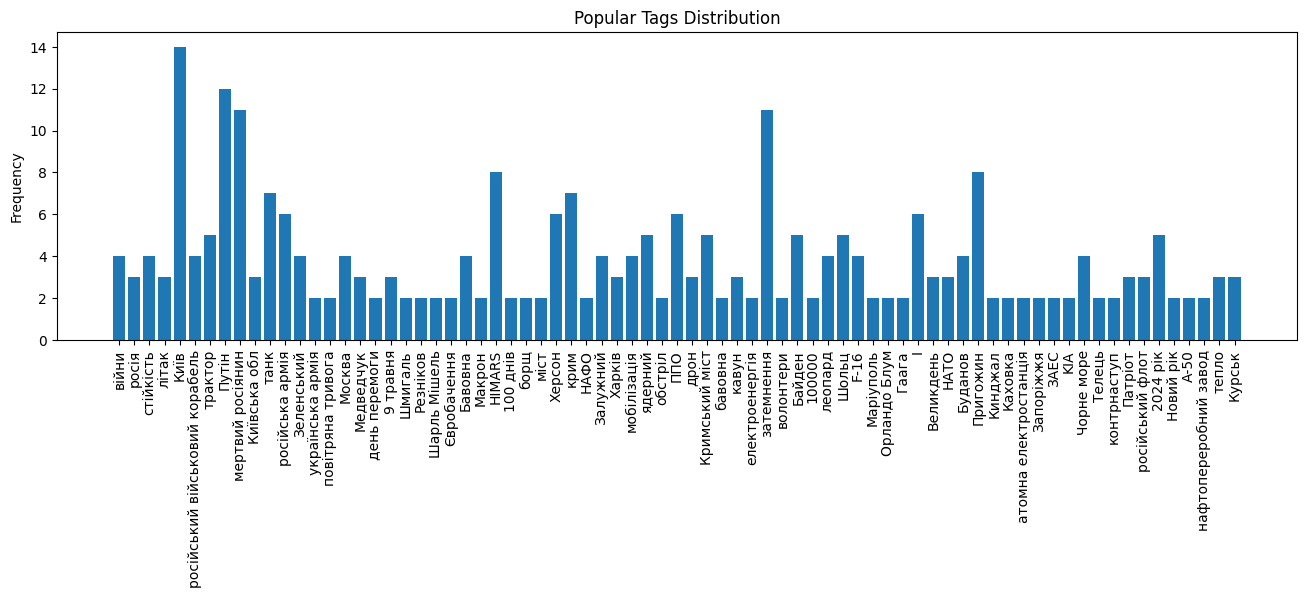

In [28]:
plt.figure(figsize=(16, 4))
plt.bar(popular_tags_counts.keys(), popular_tags_counts.values())
plt.title('Popular Tags Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

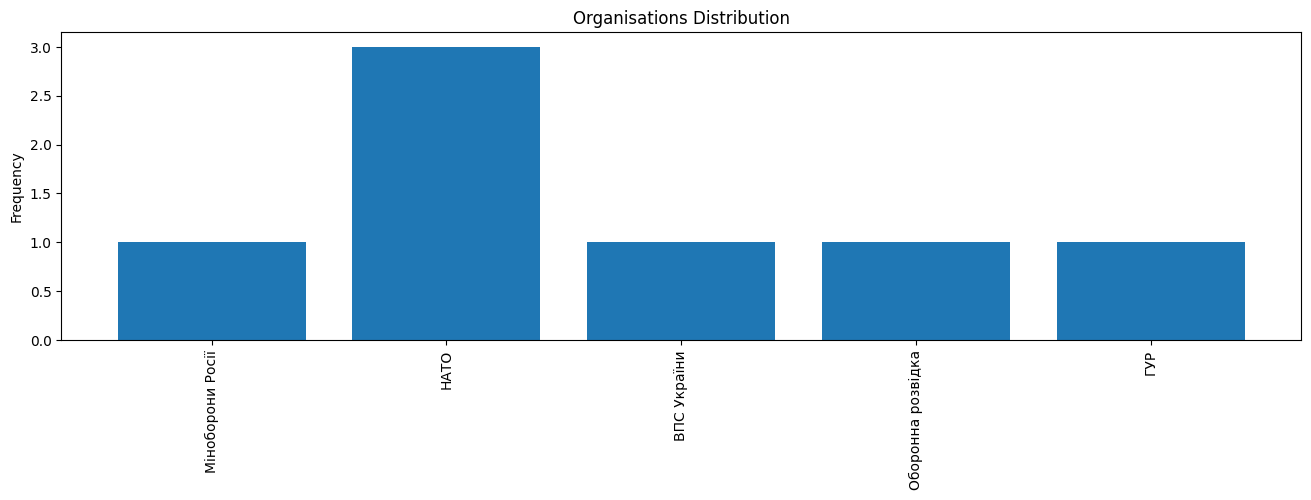

In [33]:
organization_names = memes_df[memes_df.organization_name.notna()].organization_name.str.split(';')
organization_names_list = [item for sublist in organization_names for item in sublist]
organization_names_counts = dict(Counter(organization_names_list))

plt.figure(figsize=(16, 4))
plt.bar(organization_names_counts.keys(), organization_names_counts.values())
plt.title('Organisations Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

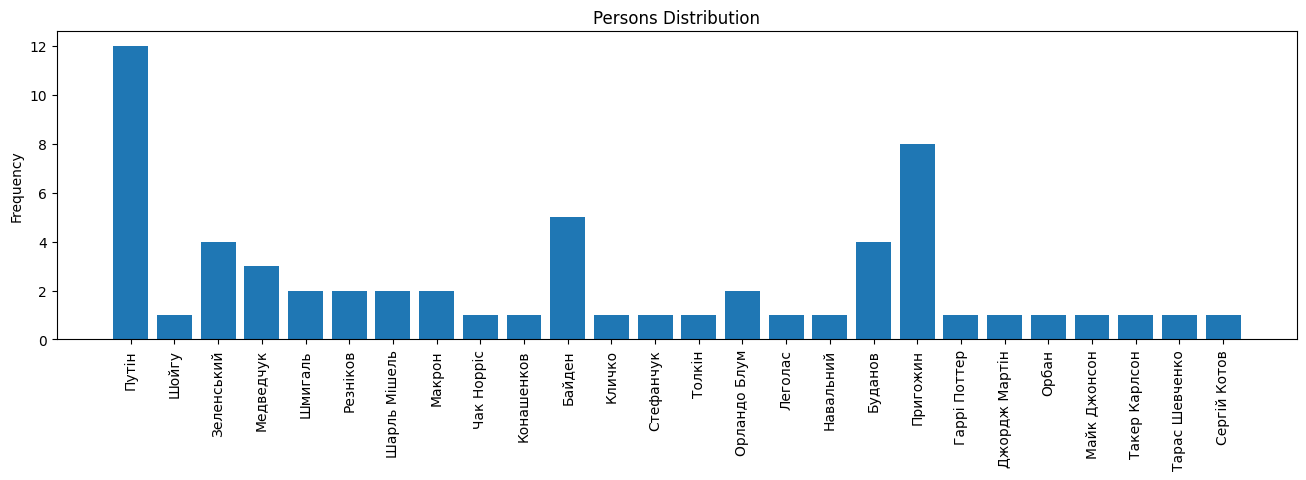

In [30]:
person_names = memes_df[memes_df.person_name.notna()].person_name.str.split(';')
person_names_list = [item for sublist in person_names for item in sublist]
person_names_counts = dict(Counter(person_names_list))

plt.figure(figsize=(16, 4))
plt.bar(person_names_counts.keys(), person_names_counts.values())
plt.title('Persons Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

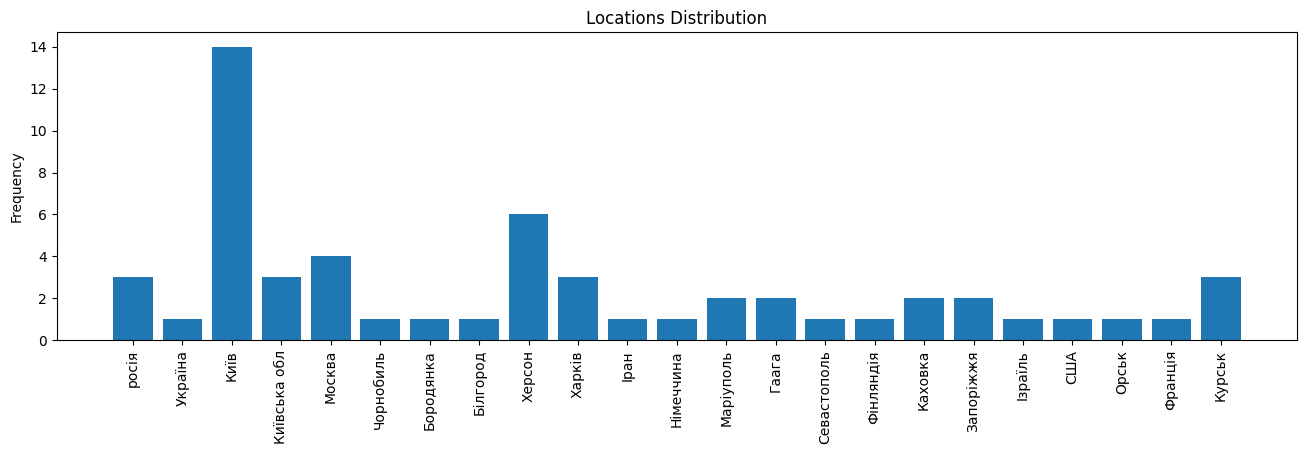

In [31]:
location_names = memes_df[memes_df.location_name.notna()].location_name.str.split(';')
location_names_list = [item for sublist in location_names for item in sublist]
location_names_counts = dict(Counter(location_names_list))

plt.figure(figsize=(16, 4))
plt.bar(location_names_counts.keys(), location_names_counts.values())
plt.title('Locations Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

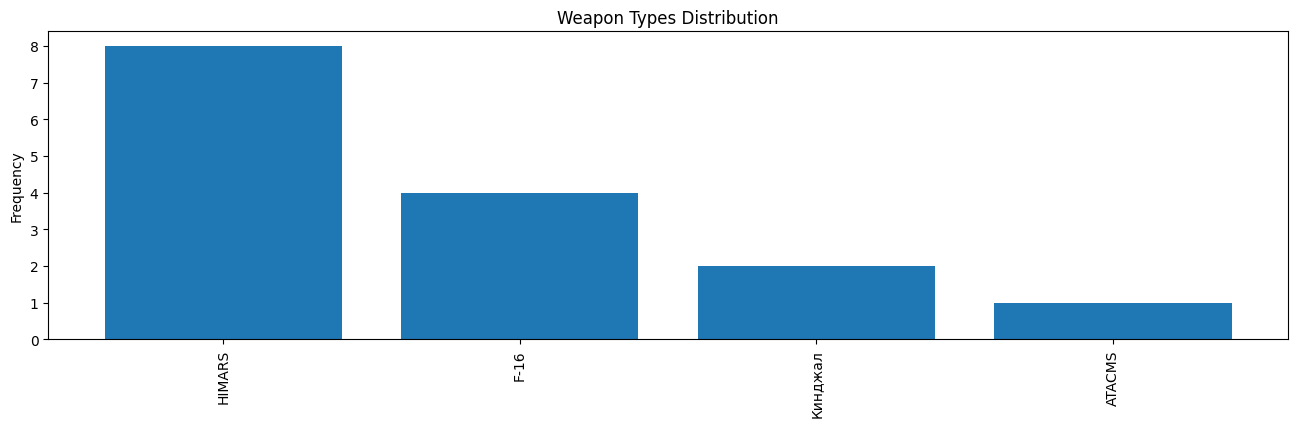

In [32]:
weapon_names = memes_df[memes_df.weapon_name.notna()].weapon_name.str.split(';')
weapon_names_list = [item for sublist in weapon_names for item in sublist]
weapon_names_counts = dict(Counter(weapon_names_list))

plt.figure(figsize=(16, 4))
plt.bar(weapon_names_counts.keys(), weapon_names_counts.values())
plt.title('Weapon Types Distribution')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()